In [1]:
import os
import glob
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


 Loads image pairs from the OTB100 dataset for training SiamFC

In [2]:
class OTBPairDataset(Dataset):
    def __init__(self, root_dir, crop_size=127, search_size=255, frame_gap=4):
        self.pairs = []
        self.crop_size = crop_size
        self.search_size = search_size

        # Traverse all video directories
        video_dirs = sorted(glob.glob(os.path.join(root_dir, "*")))
        for vdir in video_dirs:
            img_dir = os.path.join(vdir, "img")
            gt_path = os.path.join(vdir, "groundtruth_rect.txt")
            if not os.path.exists(img_dir) or not os.path.exists(gt_path):
                continue

            # Load image paths and ground truth boxes
            img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
            with open(gt_path, 'r') as f:
                lines = f.readlines()
            gt = [list(map(float, line.strip().replace(',', ' ').split())) for line in lines]

            # Ensure the number of images and ground truth boxes match
            min_len = min(len(img_paths), len(gt))
            if min_len <= frame_gap:
                continue  # Skip sequences that are too short

            img_paths = img_paths[:min_len]
            gt = gt[:min_len]

            # Generate pairs with frame_gap between them
            for i in range(min_len - frame_gap):
                self.pairs.append((img_paths[i], img_paths[i + frame_gap],
                                   gt[i], gt[i + frame_gap]))

    def __len__(self):
        return len(self.pairs)

    def crop_patch(self, img, bbox, size, context_amount=0.5):
        x, y, w, h = bbox
        cx, cy = x + w / 2, y + h / 2
        context = context_amount * (w + h)
        sz = np.sqrt((w + context) * (h + context))
        scale = size / sz

        # Crop a square region centered at (cx, cy)
        patch = cv2.getRectSubPix(img, (int(sz), int(sz)), (cx, cy))
        if patch is None or patch.size == 0:
            return None, None

        patch = cv2.resize(patch, (size, size))
        return patch, scale

    def __getitem__(self, idx):
        img_z_path, img_x_path, box_z, box_x = self.pairs[idx]
        img_z = cv2.imread(img_z_path)
        img_x = cv2.imread(img_x_path)

        # Retry next index if image loading failed
        if img_z is None or img_x is None:
            return self.__getitem__((idx + 1) % len(self.pairs))

        # Crop template and search patches
        z_crop, _ = self.crop_patch(img_z, box_z, self.crop_size)
        x_crop, _ = self.crop_patch(img_x, box_x, self.search_size)

        # Retry next index if cropping failed
        if z_crop is None or x_crop is None:
            return self.__getitem__((idx + 1) % len(self.pairs))

        # Normalize to [0, 1]
        z_crop = z_crop.astype(np.float32) / 255.0
        x_crop = x_crop.astype(np.float32) / 255.0

        # Convert to CHW format and torch tensor
        z_tensor = torch.from_numpy(z_crop.transpose(2, 0, 1))
        x_tensor = torch.from_numpy(x_crop.transpose(2, 0, 1))

        return z_tensor, x_tensor


Build SiamFC model using shared convolutional layer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiamFC(nn.Module):
    def __init__(self):
        super(SiamFC, self).__init__()
        # Basic CNN feature extractor shared by both branches
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3)  # last layer, no activation
        )

    def forward(self, z, x):
        f_z = self.feature_extractor(z)
        f_x = self.feature_extractor(x)
        return self.cross_correlation(f_z, f_x)

    def cross_correlation(self, z_feat, x_feat):
        # Do conv2d where template features act as filters
        out = []
        for i in range(x_feat.size(0)):
            response = F.conv2d(
                x_feat[i:i+1],     # search feature
                z_feat[i:i+1]      # template feature as kernel
            )
            out.append(response)
        return torch.cat(out, dim=0)


In [4]:
import torch.optim as optim

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move it to the device
model = SiamFC().to(device)


criterion = nn.MSELoss()

# Adam optimizer with small weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Basic training setup
num_epochs = 5
batch_size = 64


Train the SiamFC model with OTB100 dataset

In [5]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Enable optimized cuDNN kernels for consistent input sizes
torch.backends.cudnn.benchmark = True

# Generate a 2D Gaussian response map with peak at center
def generate_gaussian_response(size=17, sigma=3):
    x = np.arange(0, size) - size // 2
    y = np.arange(0, size) - size // 2
    xx, yy = np.meshgrid(x, y)
    heatmap = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    heatmap = heatmap / heatmap.max()
    return torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, size, size]

# Load image pairs from OTB dataset
dataset = OTBPairDataset("./data/OTB100/unzipped")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                    pin_memory=True, num_workers=0)

# Precompute the target heatmap and move to device
gt_response = generate_gaussian_response(size=17, sigma=2.5).to(device)

# Start training loop
loss_curve = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for z, x in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        z = z.to(device, non_blocking=True)
        x = x.to(device, non_blocking=True)

        optimizer.zero_grad()
        response = model(z, x)

        # Use the same Gaussian map as the ground truth for every sample
        gt = gt_response.expand_as(response)
        loss = criterion(response, gt)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_curve.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")


Epoch 1/5:  39%|███▊      | 341/882 [02:36<04:12,  2.14it/s]C:\Users\joewu\AppData\Local\Temp\ipykernel_40432\353059004.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  scale = size / sz
Epoch 1/5: 100%|██████████| 882/882 [06:24<00:00,  2.30it/s]


Epoch 1 - Avg Loss: 9.6286


Epoch 2/5: 100%|██████████| 882/882 [05:39<00:00,  2.60it/s]


Epoch 2 - Avg Loss: 0.0379


Epoch 3/5: 100%|██████████| 882/882 [05:37<00:00,  2.62it/s]


Epoch 3 - Avg Loss: 0.0343


Epoch 4/5: 100%|██████████| 882/882 [05:37<00:00,  2.61it/s]


Epoch 4 - Avg Loss: 0.0316


Epoch 5/5: 100%|██████████| 882/882 [05:32<00:00,  2.65it/s]

Epoch 5 - Avg Loss: 0.0290


Response Map 

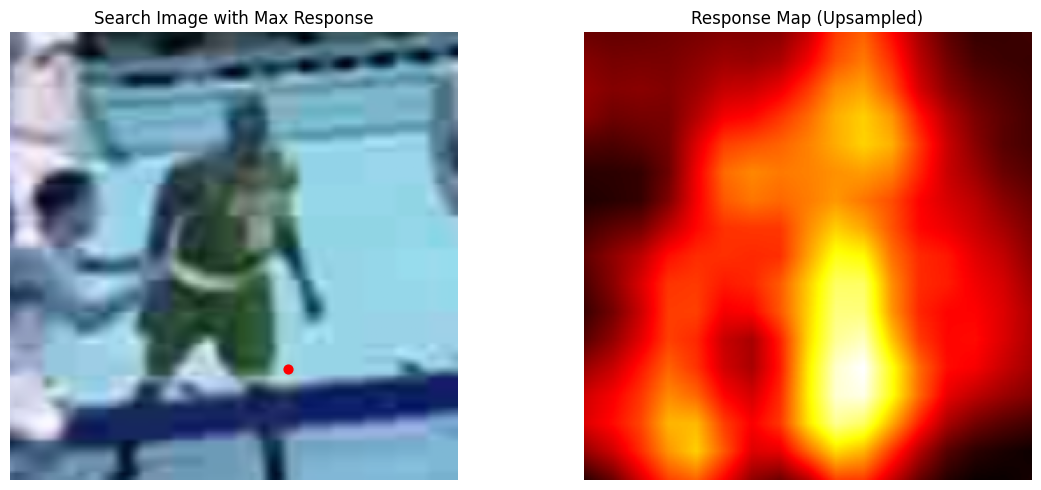

In [6]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Grab a template-search pair from the dataset
z, x = dataset[0]
z = z.unsqueeze(0).to(device)  # add batch dim
x = x.unsqueeze(0).to(device)

# Run model to get response map
model.eval()
with torch.no_grad():
    response = model(z, x)  # shape: [1, 1, H, W]

    # Upsample the response map for better visualization
    response = F.interpolate(response, size=(255, 255), mode='bilinear', align_corners=True)
    response_map = response.squeeze().cpu().numpy()

# Normalize the heatmap to [0, 1] for display
response_map -= response_map.min()
response_map /= response_map.max()

# Find the peak location
max_pos = np.unravel_index(np.argmax(response_map), response_map.shape)

# Convert search image to numpy for display
x_np = x.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot the search image with red dot at max response, and the response map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_np)
plt.title("Search Image with Max Response")
plt.scatter(max_pos[1], max_pos[0], color='red', s=40)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(response_map, cmap='hot')
plt.title("Response Map (Upsampled)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
import os

# Path to save the trained weights
save_path = "./siamfc_weights.pth"

# Save model state dictionary
torch.save(model.state_dict(), save_path)
print(f" Model weights saved to: {save_path}")


 Model weights saved to: ./siamfc_weights.pth


Loads the trained SiamFC model and runs it frame by frame on a video

In [6]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained SiamFC model
model = SiamFC().to(device)
model.load_state_dict(torch.load("siamfc_weights.pth"))
model.eval()

# Open input video
video_path = "input.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set up output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output.mp4", fourcc, fps, (w, h))

# Select target in the first frame
ret, first_frame = cap.read()
init_box = cv2.selectROI("Select Target", first_frame, fromCenter=False, showCrosshair=True)
cv2.destroyWindow("Select Target")

x, y, w_box, h_box = init_box
cx, cy = x + w_box / 2, y + h_box / 2

# Crop and preprocess template patch
z_crop = cv2.getRectSubPix(first_frame, (127, 127), (cx, cy))
z_crop = z_crop.astype(np.float32) / 255.0
z_tensor = torch.from_numpy(z_crop.transpose(2, 0, 1)).unsqueeze(0).to(device)

# Save the first frame as-is
out.write(first_frame)

# Start tracking loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Crop search region centered at current (cx, cy)
    x_crop = cv2.getRectSubPix(frame, (255, 255), (cx, cy))
    x_crop = x_crop.astype(np.float32) / 255.0
    x_tensor = torch.from_numpy(x_crop.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        response = model(z_tensor, x_tensor)
        response = F.interpolate(response, size=(255, 255), mode='bilinear', align_corners=True)
        response_map = response.squeeze().cpu().numpy()
        response_map = cv2.GaussianBlur(response_map, (5, 5), 0)  # smooth out noise

    # Get peak response location
    max_pos = np.unravel_index(np.argmax(response_map), response_map.shape)

    # Compute offset from center
    dx, dy = max_pos[1] - 127, max_pos[0] - 127

    # Smooth movement using exponential moving average
    alpha = 0.7
    cx = alpha * (cx + dx) + (1 - alpha) * cx
    cy = alpha * (cy + dy) + (1 - alpha) * cy

    # Draw tracking box using original size
    top_left = (int(cx - w_box / 2), int(cy - h_box / 2))
    bottom_right = (int(cx + w_box / 2), int(cy + h_box / 2))
    cv2.rectangle(frame, top_left, bottom_right, (0, 0, 255), 2)
    out.write(frame)

    # Optional visualization
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
        break

cap.release()
out.release()
cv2.destroyAllWindows()


Evaluation

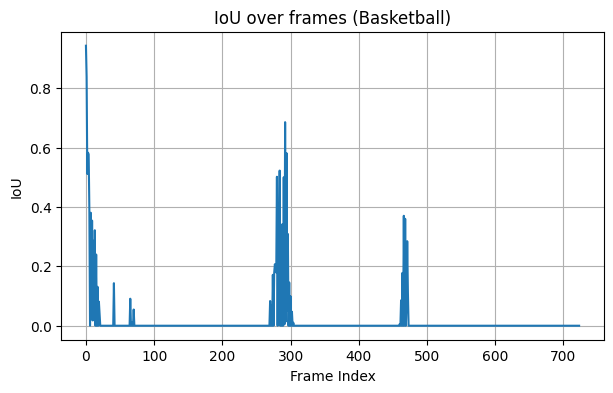

In [10]:
import os
import glob
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Compute IoU between two boxes in (x, y, w, h) format
def compute_iou(boxA, boxB):
    xa, ya, wa, ha = boxA
    xb, yb, wb, hb = boxB
    xa1, ya1, xa2, ya2 = xa, ya, xa + wa, ya + ha
    xb1, yb1, xb2, yb2 = xb, yb, xb + wb, yb + hb

    inter_x1 = max(xa1, xb1)
    inter_y1 = max(ya1, yb1)
    inter_x2 = min(xa2, xb2)
    inter_y2 = min(ya2, yb2)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    areaA = wa * ha
    areaB = wb * hb
    union_area = areaA + areaB - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Load Basketball sequence and ground truth boxes
video_dir = "./data/OTB100/unzipped/Basketball"
img_paths = sorted(glob.glob(os.path.join(video_dir, "img/*.jpg")))
gt_path = os.path.join(video_dir, "groundtruth_rect.txt")
with open(gt_path, "r") as f:
    gt_boxes = [list(map(float, line.strip().replace(',', ' ').split())) for line in f.readlines()]

# Initialize tracker with first frame and ground truth box
first_img = cv2.imread(img_paths[0])
init_box = gt_boxes[0]
cx, cy = init_box[0] + init_box[2]/2, init_box[1] + init_box[3]/2

z_crop = cv2.getRectSubPix(first_img, (127, 127), (cx, cy))
z_crop = z_crop.astype(np.float32) / 255.0
z_tensor = torch.from_numpy(z_crop.transpose(2, 0, 1)).unsqueeze(0).to(device)

# Run tracker frame-by-frame
ious = []
for i, path in enumerate(img_paths[1:], start=1):
    img = cv2.imread(path)
    x_crop = cv2.getRectSubPix(img, (255, 255), (cx, cy))
    x_crop = x_crop.astype(np.float32) / 255.0
    x_tensor = torch.from_numpy(x_crop.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        response = model(z_tensor, x_tensor)
        response = F.interpolate(response, size=(255, 255), mode='bilinear', align_corners=True)
        response_map = response.squeeze().cpu().numpy()
        max_pos = np.unravel_index(np.argmax(response_map), response_map.shape)

    dx, dy = max_pos[1] - 127, max_pos[0] - 127
    cx += dx
    cy += dy

    # Construct predicted box and compute IoU with ground truth
    pred_box = [cx - init_box[2]/2, cy - init_box[3]/2, init_box[2], init_box[3]]
    iou = compute_iou(pred_box, gt_boxes[i])
    ious.append(iou)

# Plot IoU over frames
plt.figure(figsize=(7, 4))
plt.plot(ious)
plt.title("IoU over frames (Basketball)")
plt.xlabel("Frame Index")
plt.ylabel("IoU")
plt.grid(True)
plt.show()


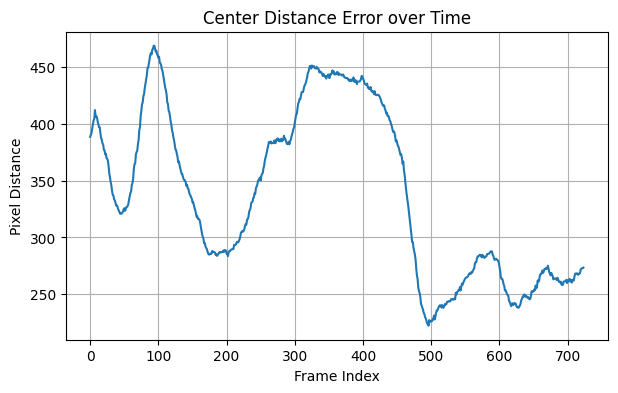

In [11]:
errors = []

# Compute Euclidean distance between predicted center and ground truth center
for i in range(1, len(gt_boxes)):
    gt_cx = gt_boxes[i][0] + gt_boxes[i][2] / 2
    gt_cy = gt_boxes[i][1] + gt_boxes[i][3] / 2
    error = np.sqrt((cx - gt_cx)**2 + (cy - gt_cy)**2)
    errors.append(error)

# Plot the tracking error over time
plt.figure(figsize=(7, 4))
plt.plot(errors)
plt.title("Center Distance Error over Time")
plt.xlabel("Frame Index")
plt.ylabel("Pixel Distance")
plt.grid(True)
plt.show()
